In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from openbb import obb
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

In [2]:
obb.user.preferences.output_type = "dataframe"

In [3]:
# load which stocks we want to analyze in our portfolio along with SPY benchmark
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "SPY"]

In [4]:
# retrieve the prices data for the stocks
data = obb.equity.price.historical(
    symbols,
    start_date="2017-01-01",
    end_date="2024-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

In [5]:
# calculate the monthly returns and conver the index to a monthly period
monthly_returns = data.asfreq("ME").pct_change(fill_method=None).to_period("M")

In [6]:
display(monthly_returns)

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SPY,SSRM,UNH
date,,,,,,,,,
2017-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,-0.262661,0.079117,0.075036,0.062591,-0.056229,-0.084800,0.039292,0.050142,0.020234
2017-03,-0.059371,0.019147,0.015699,-0.035373,-0.037383,0.060560,-0.003087,-0.044144,-0.008284
2017-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10,-0.063953,-0.013575,-0.063435,-0.098978,-0.149860,0.041055,-0.008924,0.086268,-0.034515


In [7]:
# Calculate the active returns and use them as the dependent variable to help understand the
# senstivity of the Fama-french factors to our active returns
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = (R - bench).dropna()

In [8]:
# Load the fama french data
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start="2017-01-01",
    end="2024-12-31",
)[0][1:] / 100
SMB = factors.loc[active.index, "SMB"]
HML = factors.loc[active.index, "HML"]

C:\Users\tsebo\AppData\Local\Temp\ipykernel_13476\3290778748.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench(
C:\Users\tsebo\AppData\Local\Temp\ipykernel_13476\3290778748.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench(


In [9]:
help(pdr.get_data_famafrench)

Help on function get_data_famafrench in module pandas_datareader.data:

get_data_famafrench(*args, **kwargs)



In [10]:
# A dataframe that aligns the data along common date index
df = pd.DataFrame(
    {
        "R": active,
        "SMB": SMB,
        "HML": HML,
    },
    index=active.index
).dropna()

In [11]:
# Execute the regression & get the beta coefficients for each factor
# These coefficients represent the exposures of our active returns to the Fama-French factors
b1, b2 = regression.linear_model.OLS(
    df.R,
    df[["SMB", "HML"]]
).fit().params

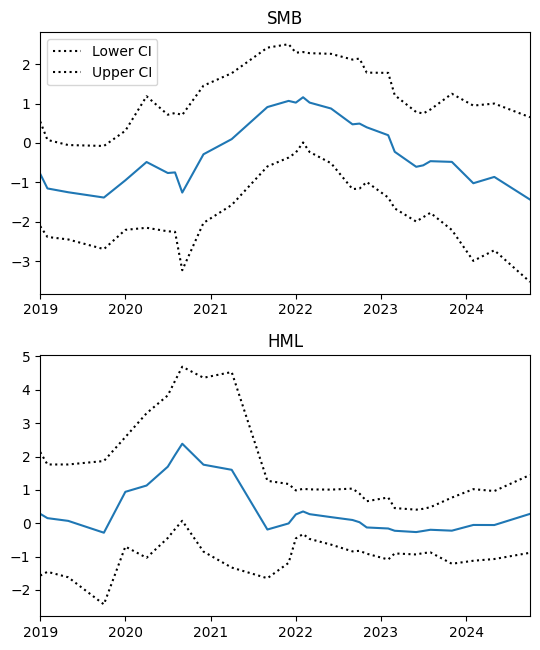

In [12]:
# Using the Statsmodels RollingOLS class to see how the sensitivies evolve through time
exog = sm.add_constant(df[["SMB", "HML"]])
rols = RollingOLS(active, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(
    variables=["SMB", "HML"],
    figsize=(5.5, 6.6)
)

In [13]:
F1 = df.SMB
F2 = df.HML
cov = np.cov(F1, F2)
ar_squared = (active.std()) ** 2
mcar1 = (b1 * (b2 * cov[0, 1] + b1 * cov[0,1])) / ar_squared
mcar2 = (b2 * (b1 * cov[0, 1] + b2 * cov[1, 1])) / ar_squared
print(f"SMB risk contribution: {mcar1}")
print(f"HML risk contribution: {mcar2}")
print(f"Unexplained risk contribution: { 1 - (mcar1 + mcar2)}")

SMB risk contribution: -0.0006946925443540328
HML risk contribution: 9.088211316974994e-05
Unexplained risk contribution: 1.0006038104311843


In [14]:
# calculate the 12 month rolling covariances between the factors
covariances = (
    df[["SMB", "HML"]]
    .rolling(window=12)
    .cov()
).dropna()

In [33]:
# calculate the 12 month rolling active return squared
active_risk_squared = (
    active.rolling(window=12).std()**2
).dropna()

In [35]:
# combine the rolling factor betas
betas = pd.concat(
    [rres.params.SMB, rres.params.HML],
    axis=1
).dropna()

In [37]:
# empty DataFrame to store the rolling MCAR data
MCAR = pd.DataFrame(
    index=betas.index,
    columns=betas.columns
)

In [45]:
# loop through the factors and dates calculating the MCAR data
for factor in betas.columns:
    for t in betas.index:
        s = np.sum(
            betas.loc[t] * covariances.loc[t][factor])
        b = betas.loc[t][factor]
        AR = active_risk_squared.loc[t]
        MCAR[factor][t] = b * s / AR


C:\Users\tsebo\AppData\Local\Temp\ipykernel_13476\3897640542.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  MCAR[factor][t] = b * s / AR


<Axes: xlabel='date'>

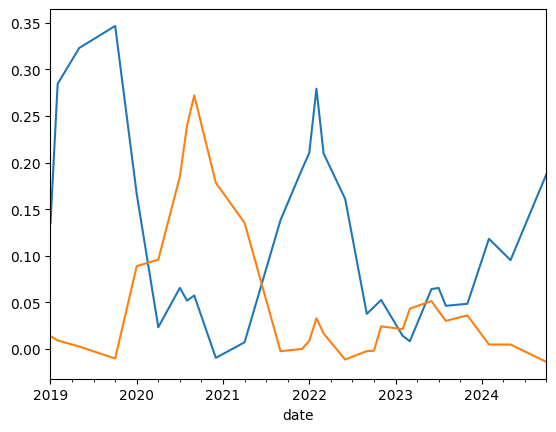

In [49]:
# Plot the MCAR estimates for each factor
MCAR.SMB.plot()
MCAR.HML.plot()

<Axes: xlabel='date'>

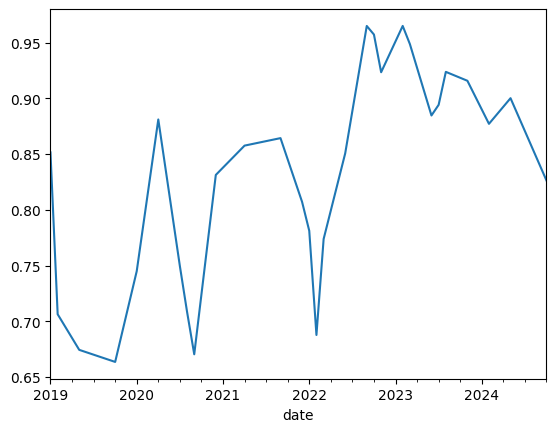

In [51]:
# Plot the unexplained risk contribution
(1 - (MCAR.SMB + MCAR.HML)).plot()